In [1]:
#Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
# My portfolio
portfolio = {
    'AAPL': 10,   # Apple Inc.
    'MSFT': 50,    # Microsoft Corporation
    'GOOGL': 20,   # Alphabet Inc.
    'AMZN': 10,    # Amazon.com Inc.
    'TSLA': 15,    # Tesla Inc.
    'JNJ': 30,     # Johnson & Johnson
    'V': 40,       # Visa Inc.
    'NVDA': 10,    # NVIDIA Corporation
}

In [3]:
# Individual stock prices over time
def download_stock_data(ticker, start_date, end_date):
    """
    Download historical stock data for a given ticker.
    """
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data['Ticker'] = ticker
    stock_data.reset_index(inplace=True)
    # Only select columns that exist
    columns_to_select = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
   
    stock_data = stock_data[columns_to_select]
    stock_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Ticker']
    stock_data['Date'] = pd.to_datetime(stock_data['Date']).dt.strftime('%Y-%m-%d')
    return pd.DataFrame(stock_data)

# Define the list of tickers and date range (from 1 year ago to today format YYYY-MM-DD)
tickers = list(portfolio.keys()) # ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'JNJ', 'V', 'FB', 'NVDA']
end_date = dt.datetime.now().strftime('%Y-%m-%d')
start_date = (dt.datetime.now() - dt.timedelta(days=365)).strftime('%Y-%m-%d')

# Download data for all tickers
all_stock_data = pd.concat([download_stock_data(ticker, start_date, end_date) for ticker in tickers], axis=0)
all_stock_data.reset_index(drop=True, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Starting date: 2024-09-23, Ending date: 2025-09-19


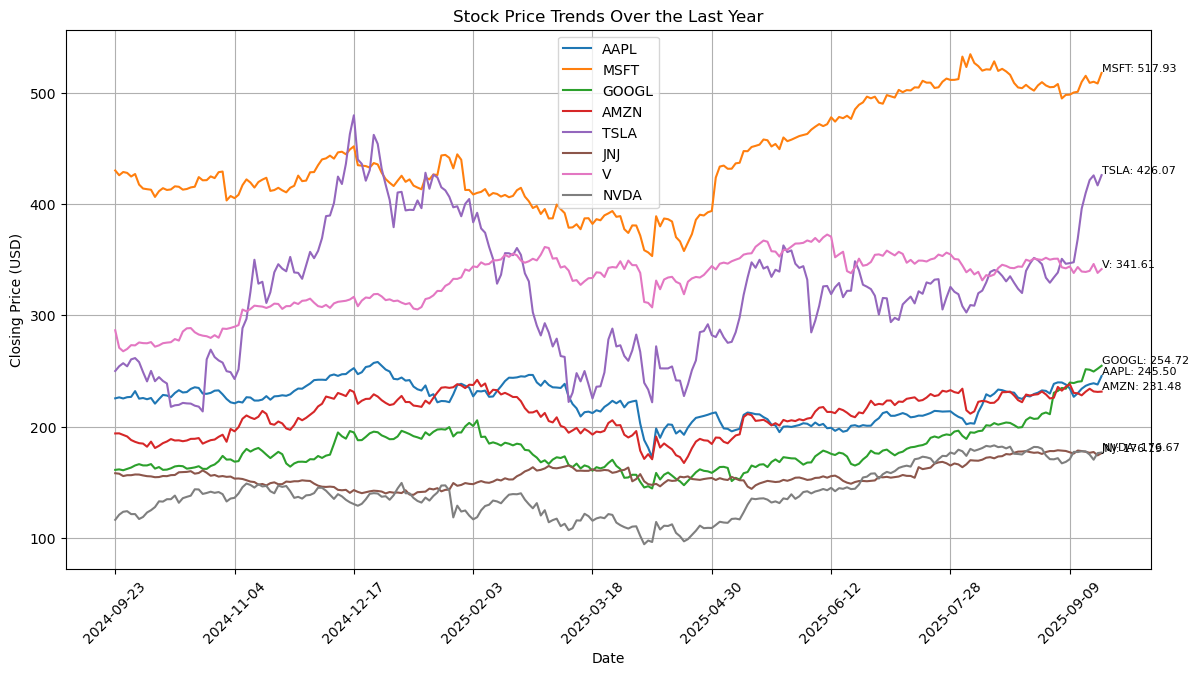

In [4]:
# Plot stock price trends
print(f'Starting date: {all_stock_data["Date"].min()}, Ending date: {all_stock_data["Date"].max()}')
plt.figure(figsize=(14, 7))
for ticker in tickers:
    ticker_data = all_stock_data[all_stock_data['Ticker'] == ticker]
    plt.plot(ticker_data['Date'], ticker_data['Close'], label=ticker)
plt.title('Stock Price Trends Over the Last Year')
plt.xlabel('Date')
# Show x-axis labels every 30 days
plt.xticks(ticks=range(0, len(all_stock_data['Date'].unique()), 30), labels=all_stock_data['Date'].unique()[::30], rotation=45)
# Show last price in line
for ticker in tickers:
    ticker_data = all_stock_data[all_stock_data['Ticker'] == ticker]
    plt.text(ticker_data['Date'].values[-1], ticker_data['Close'].values[-1], f"{ticker}: {ticker_data['Close'].values[-1]:.2f}", fontsize=8, verticalalignment='bottom')
plt.ylabel('Closing Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

Starting date: 2024-09-23, Ending date: 2025-09-19


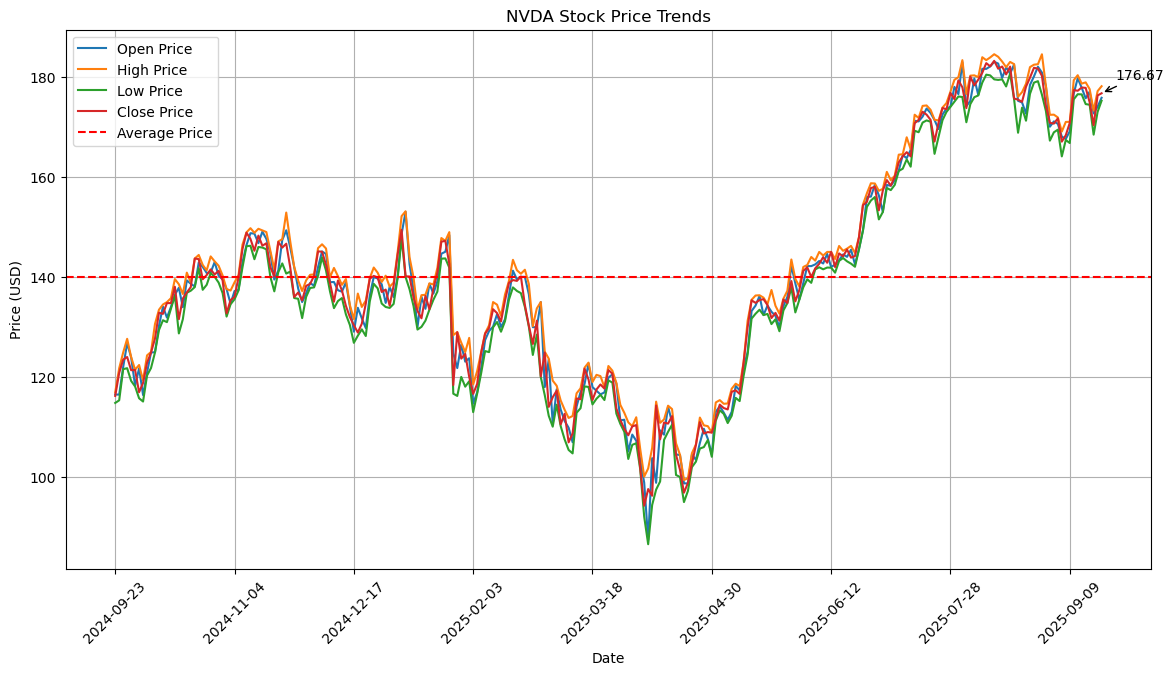

In [5]:
# Plot stock price trends (open, high, low, close)
ticker = 'NVDA'  # Change this to any ticker in your portfolio
print(f'Starting date: {all_stock_data["Date"].min()}, Ending date: {all_stock_data["Date"].max()}')
ticker_data = all_stock_data[all_stock_data['Ticker'] == ticker]
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Date'], ticker_data['Open'], label='Open Price')
plt.plot(ticker_data['Date'], ticker_data['High'], label='High Price')
plt.plot(ticker_data['Date'], ticker_data['Low'], label='Low Price')
plt.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.title(f'{ticker} Stock Price Trends')
# Show x-axis labels every 30 days
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
# Show last price in line
plt.annotate(f"{ticker_data['Close'].values[-1]:.2f}", xy=(ticker_data['Date'].values[-1], ticker_data['Close'].values[-1]), xytext=(10, 10), textcoords="offset points", arrowprops=dict(arrowstyle="->"))
# Show the average price line
plt.axhline(y=ticker_data['Close'].mean(), color='r', linestyle='--', label='Average Price')
plt.legend()
plt.grid()
plt.show()

- Open price means the price at which a stock starts trading when the market opens for the day.
- Close price means the price at which a stock ends trading when the market closes for the day.
- High price means the highest price at which a stock traded during the day.
- Low price means the lowest price at which a stock traded during the day.

In [6]:
# Momentum/Overbought/Oversold Indicator: Stochastic Oscillator (STO) and Relative Strength Index (RSI)
ticker = 'NVDA'  # Change this to any ticker in the portfolio
ticker_data = all_stock_data[all_stock_data['Ticker'] == ticker].copy()
# The lowest low and highest high over the last 14 periods
lowest_low = ticker_data['Low'].rolling(14, min_periods=14).min()
highest_high = ticker_data['High'].rolling(14, min_periods=14).max()
rng = highest_high - lowest_low
# Avoid division by zero
rng[rng == 0] = 1e-10
# Calculate %K and %D
ticker_data['%K'] = ((ticker_data['Close'] - lowest_low) / rng * 100).where(rng != 0)
ticker_data['%D'] = ticker_data['%K'].rolling(3, min_periods=3).mean()
# Calculate RSI
delta = ticker_data['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14, min_periods=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14, min_periods=14).mean()
rs = gain / loss
ticker_data['RSI'] = 100 - (100 / (1 + rs))
ticker_data = ticker_data.dropna()


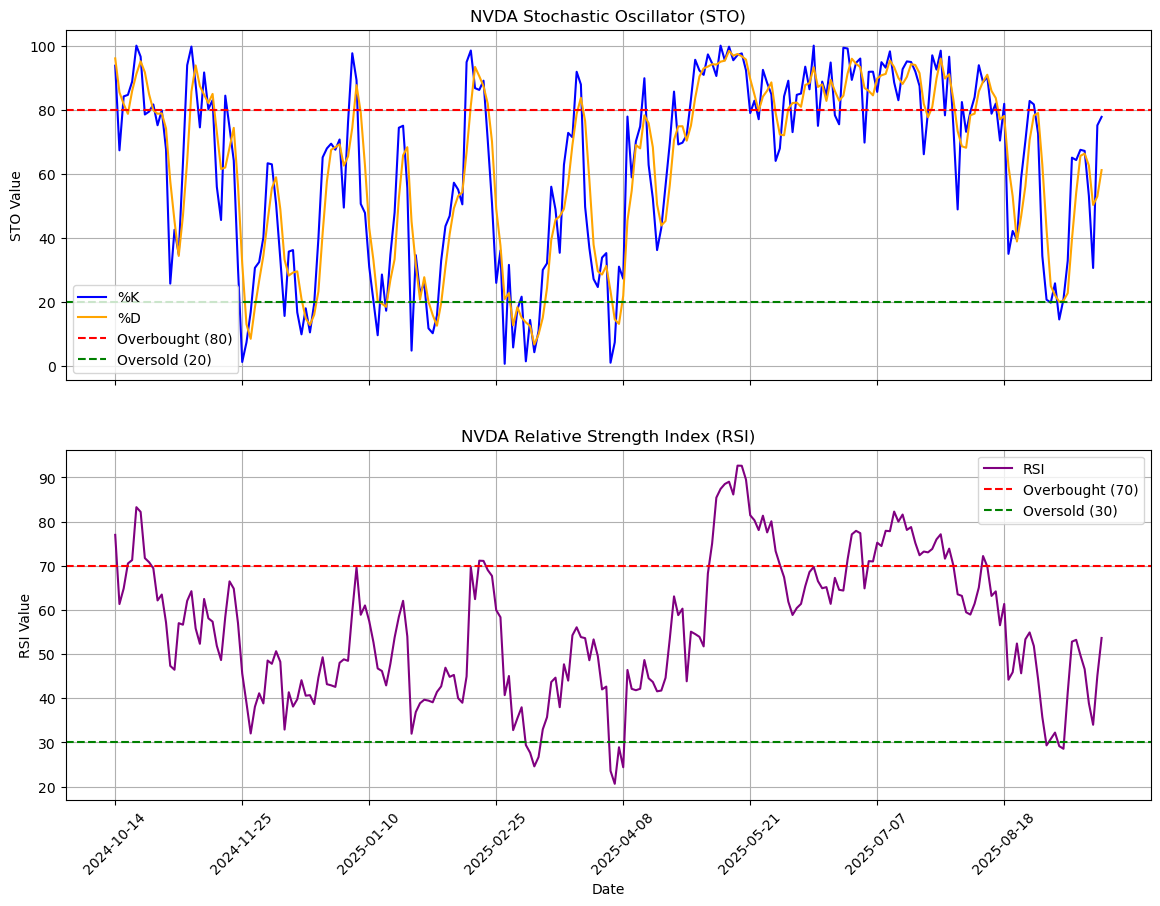

In [7]:
# Plot STO and RSI
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)
ax1.plot(ticker_data['Date'], ticker_data['%K'], label='%K', color='blue')
ax1.plot(ticker_data['Date'], ticker_data['%D'], label='%D', color='orange')
ax1.axhline(80, color='red', linestyle='--', label='Overbought (80)')
ax1.axhline(20, color='green', linestyle='--', label='Oversold (20)')
ax1.set_title(f'{ticker} Stochastic Oscillator (STO)')
ax1.set_ylabel('STO Value')
ax1.legend()
ax1.grid()
ax2.plot(ticker_data['Date'], ticker_data['RSI'], label='RSI', color='purple')
ax2.axhline(70, color='red', linestyle='--', label='Overbought (70)')
ax2.axhline(30, color='green', linestyle='--', label='Oversold (30)')
ax2.set_title(f'{ticker} Relative Strength Index (RSI)')
ax2.set_ylabel('RSI Value')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid()
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
plt.show()

            Date       Close         %K         %D        RSI  Entry  Exit
1972  2025-08-22  177.979965  58.609714  46.704907  45.647473      0     0
1973  2025-08-25  179.799866  70.216886  56.079932  53.344868      0     0
1974  2025-08-26  181.759750  82.716865  70.514488  54.901958      0     0
1975  2025-08-27  181.589767  81.632728  78.188826  51.820979      0     0
1976  2025-08-28  180.159836  72.512745  78.954112  44.324808      0     0
1977  2025-08-29  174.170166  34.311136  62.818870  35.745301      0     0
1978  2025-09-02  170.770370  20.637673  42.487184  29.325324      0     0
1979  2025-09-03  170.610382  19.710151  24.886320  30.774637      0     0
1980  2025-09-04  171.650330  25.739174  22.028999  32.223771      1     0
1981  2025-09-05  167.010590  14.460778  19.970034  29.152462      0     0
1982  2025-09-08  168.300507  20.784261  20.328071  28.553554      1     0
1983  2025-09-09  170.750366  32.794061  22.679700  41.291929      0     0
1984  2025-09-10  177.320

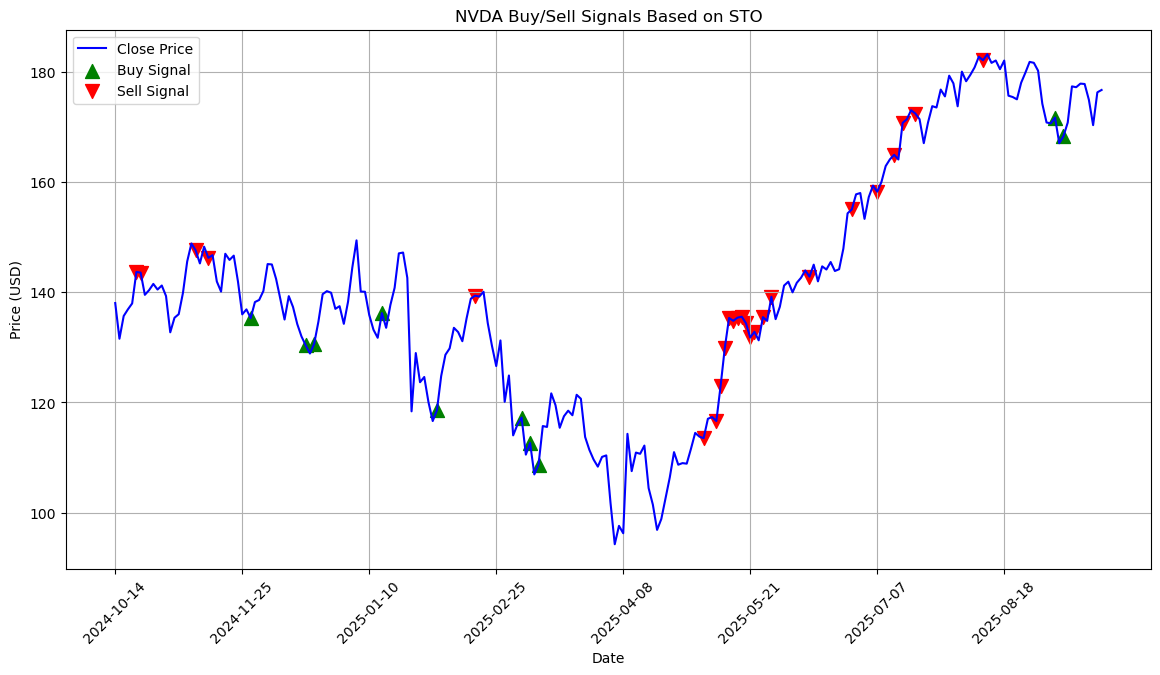

In [8]:
# Signal Generation
# Entry %K crosses above %D from below 20 (oversold)
# Exit %K crosses below %D from above 80 (overbought)
cross_up = (ticker_data['%K'].shift(1) < ticker_data['%D'].shift(1)) & (ticker_data['%K'] >= ticker_data['%D'])
cross_down = (ticker_data['%K'].shift(1) > ticker_data['%D'].shift(1)) & (ticker_data['%K'] <= ticker_data['%D'])
buy_sig = cross_up & (ticker_data['%K'] < 30) & (ticker_data['%D'] < 30) & (ticker_data['RSI'] < 50)
sell_sig = (cross_down & (ticker_data['%K'] > 80) & (ticker_data['%D'] > 80)) | (ticker_data['RSI'] > 80)
# Add signals to DataFrame 
ticker_data['Entry'] = buy_sig.astype(int)
ticker_data['Exit'] = sell_sig.astype(int)
print(ticker_data[['Date', 'Close', '%K', '%D', 'RSI', 'Entry', 'Exit']].tail(20))
# Plot buy/sell signals on price chart
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', color='blue')
plt.scatter(ticker_data.loc[ticker_data['Entry'] == 1, 'Date'], ticker_data.loc[ticker_data['Entry'] == 1, 'Close'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(ticker_data.loc[ticker_data['Exit'] == 1, 'Date'], ticker_data.loc[ticker_data['Exit'] == 1, 'Close'], marker='v', color='red', label='Sell Signal', s=100)
plt.title(f'{ticker} Buy/Sell Signals Based on STO')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
plt.show()

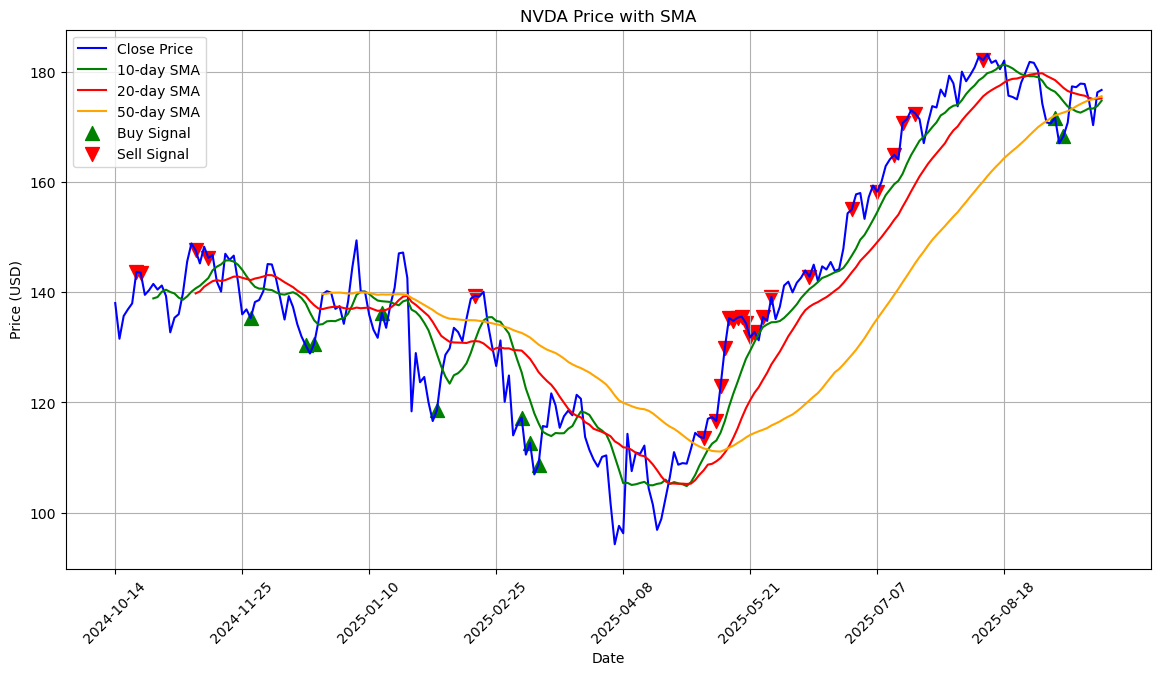

In [9]:
# Risk Management: Simple Moving Average (SMA) as dynamic stop-loss
ticker_data['SMA_10'] = ticker_data['Close'].rolling(window=10).mean()
ticker_data['SMA_20'] = ticker_data['Close'].rolling(window=20).mean()
ticker_data['SMA_50'] = ticker_data['Close'].rolling(window=50).mean()
# Plot SMA on price chart
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', color='blue')
plt.plot(ticker_data['Date'], ticker_data['SMA_10'], label='10-day SMA', color='green')
plt.plot(ticker_data['Date'], ticker_data['SMA_20'], label='20-day SMA', color='red')
plt.plot(ticker_data['Date'], ticker_data['SMA_50'], label='50-day SMA', color='orange')
plt.scatter(ticker_data.loc[ticker_data['Entry'] == 1, 'Date'], ticker_data.loc[ticker_data['Entry'] == 1, 'Close'], marker='^', color='green', label='Buy Signal', s=100)
plt.scatter(ticker_data.loc[ticker_data['Exit'] == 1, 'Date'], ticker_data.loc[ticker_data['Exit'] == 1, 'Close'], marker='v', color='red', label='Sell Signal', s=100)
plt.title(f'{ticker} Price with SMA')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
plt.show()

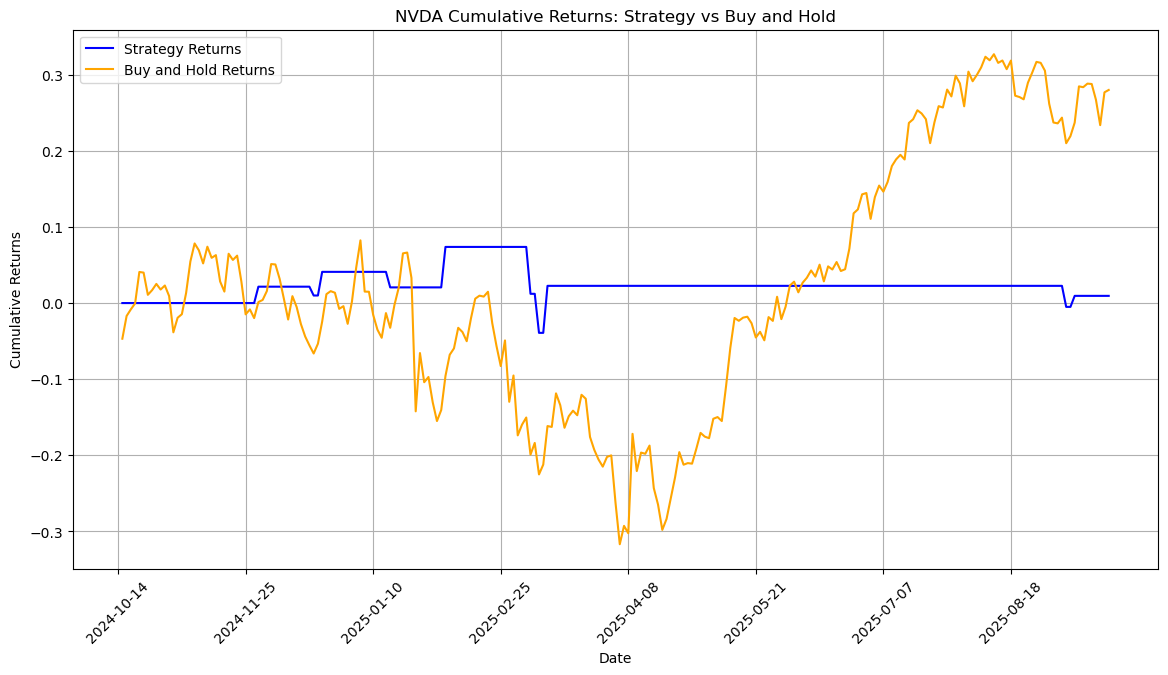

In [10]:
# Compare to buy and hold strategy
ticker_data['Position'] = 0  # 1 for holding, 0 for not holding
ticker_data.loc[ticker_data['Entry'] == 1, 'Position'] = 1
ticker_data['Position'] = ticker_data['Position'].ffill().fillna(0)  # Hold position until exit signal
ticker_data['Buy_and_Hold'] = 1  # Always holding
ticker_data['Strategy_Returns'] = ticker_data['Close'].pct_change() * ticker_data['Position'].shift(1)
ticker_data['Buy_and_Hold_Returns'] = ticker_data['Close'].pct_change() * ticker_data['Buy_and_Hold'].shift(1)
ticker_data['Cumulative_Strategy_Returns'] = (1 + ticker_data['Strategy_Returns']).cumprod() - 1
ticker_data['Cumulative_Buy_and_Hold_Returns'] = (1 + ticker_data['Buy_and_Hold_Returns']).cumprod() - 1
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Date'], ticker_data['Cumulative_Strategy_Returns'], label='Strategy Returns', color='blue')
plt.plot(ticker_data['Date'], ticker_data['Cumulative_Buy_and_Hold_Returns'], label='Buy and Hold Returns', color='orange')
plt.title(f'{ticker} Cumulative Returns: Strategy vs Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid()
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
plt.show()

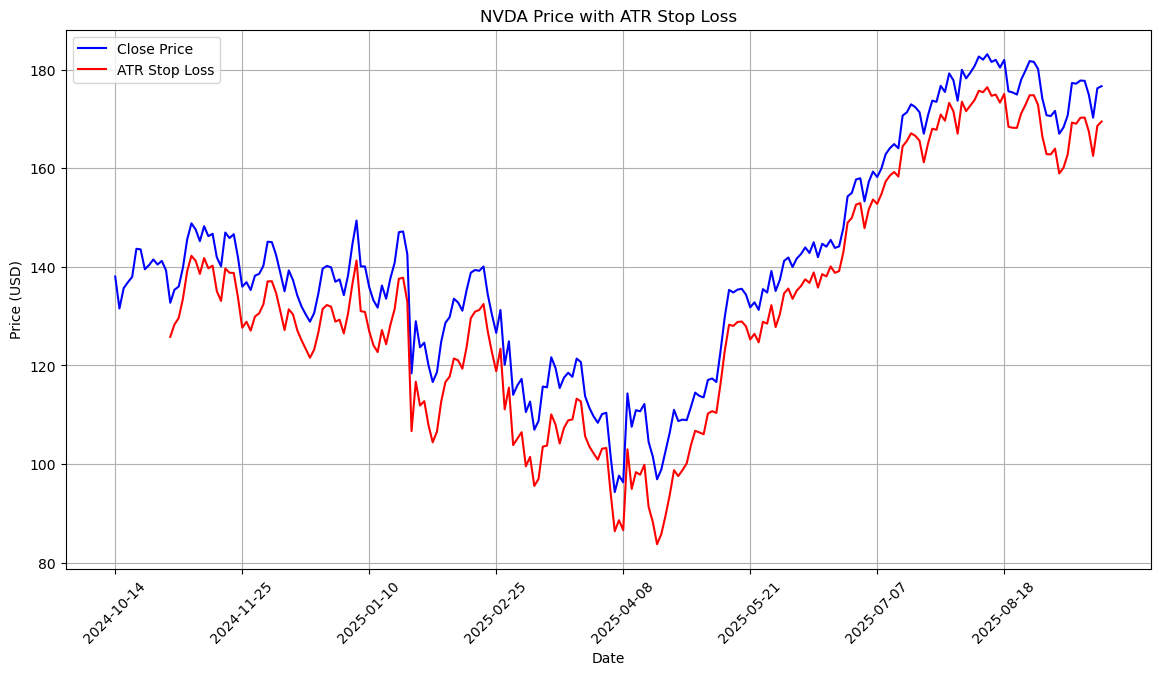

In [11]:
# Risk control ATR (Average True Range) stop loss
def calculate_atr(data, window=14):
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift())
    low_close = abs(data['Low'] - data['Close'].shift())
    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=window).mean()
    return atr

ticker_data['ATR'] = calculate_atr(ticker_data)
ticker_data['ATR_Stop_Loss'] = ticker_data['Close'] - 1.5 * ticker_data['ATR']
# Plot ATR stop loss on price chart
plt.figure(figsize=(14, 7))
plt.plot(ticker_data['Date'], ticker_data['Close'], label='Close Price', color='blue')
plt.plot(ticker_data['Date'], ticker_data['ATR_Stop_Loss'], label='ATR Stop Loss', color='red')
plt.title(f'{ticker} Price with ATR Stop Loss')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.xticks(ticks=range(0, len(ticker_data['Date']), 30), labels=ticker_data['Date'].values[::30], rotation=45)
plt.show()

In [12]:
# Fetch current stock prices
def fetch_current_prices(tickers):
    """
    Fetch current stock prices for given tickers.
    """
    data = yf.download(tickers, period='1d')
    return data['Close'].iloc[-1]

In [13]:
# Create a DataFrame to hold portfolio data
df_portfolio = pd.DataFrame(list(portfolio.items()), columns=['Ticker', 'Shares'])
tickers = df_portfolio['Ticker'].tolist()
current_prices = fetch_current_prices(tickers)
df_portfolio['Current Price'] = df_portfolio['Ticker'].map(current_prices)
df_portfolio['Total Value'] = df_portfolio['Shares'] * df_portfolio['Current Price']
df_portfolio = df_portfolio.sort_values(by='Total Value', ascending=False).reset_index(drop=True)
print(df_portfolio)

[*********************100%***********************]  8 of 8 completed

  Ticker  Shares  Current Price   Total Value
0   MSFT      50     517.929993  25896.499634
1      V      40     341.609985  13664.399414
2   TSLA      15     426.070007   6391.050110
3    JNJ      30     176.190002   5285.700073
4  GOOGL      20     254.720001   5094.400024
5   AAPL      10     245.500000   2455.000000
6   AMZN      10     231.479996   2314.799957
7   NVDA      10     176.669998   1766.699982


In [14]:
# Total portfolio value
total_portfolio_value = df_portfolio['Total Value'].sum()
print(f"\nTotal Portfolio Value: ${total_portfolio_value:,.2f}")


Total Portfolio Value: $62,868.55


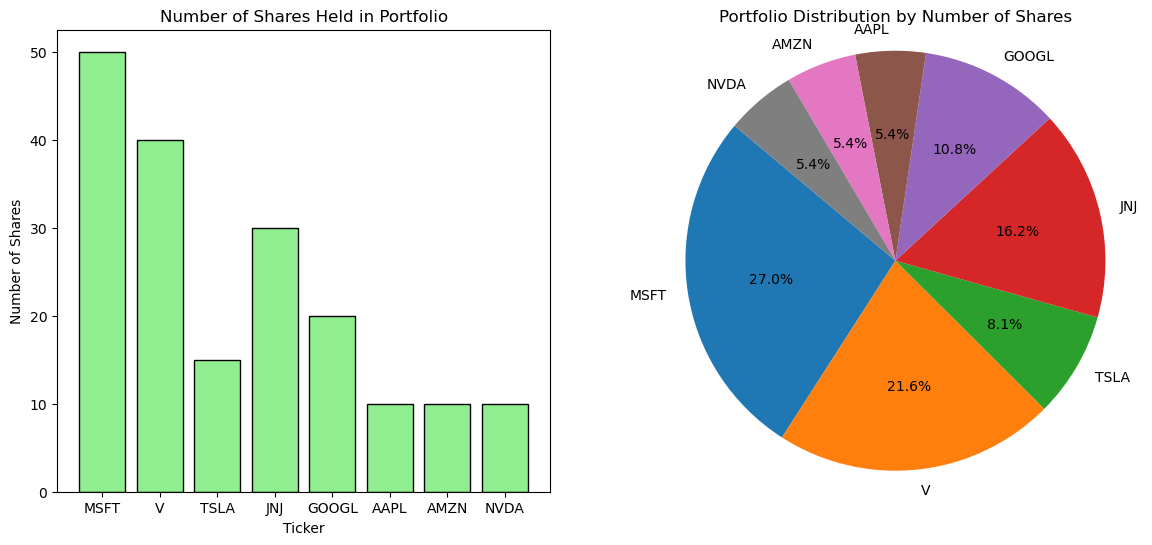

In [15]:
# Plot number of shares held
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].bar(df_portfolio['Ticker'], df_portfolio['Shares'], color='lightgreen', edgecolor='black')
ax[0].set_ylabel('Number of Shares')
ax[0].set_xlabel('Ticker')
ax[0].set_title('Number of Shares Held in Portfolio')
ax[1].pie(df_portfolio['Shares'], labels=df_portfolio['Ticker'], autopct='%1.1f%%', startangle=140)
ax[1].set_title('Portfolio Distribution by Number of Shares')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# Show the plot
plt.show()

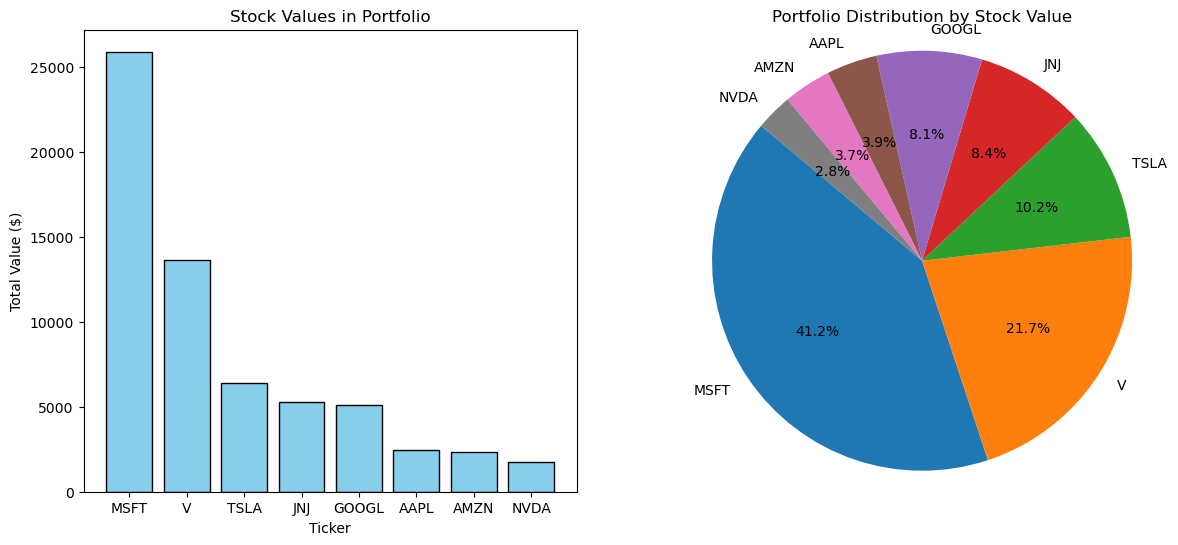

In [16]:
# Plot portfolio distribution
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
# Display Histogram of stock values and pie chart of portfolio distribution
ax[0].bar(df_portfolio['Ticker'], df_portfolio['Total Value'], color='skyblue', edgecolor='black')
ax[0].set_ylabel('Total Value ($)')
ax[0].set_xlabel('Ticker')
ax[0].set_title('Stock Values in Portfolio')
ax[1].pie(df_portfolio['Total Value'], labels=df_portfolio['Ticker'], autopct='%1.1f%%', startangle=140)
ax[1].set_title('Portfolio Distribution by Stock Value')
ax[1].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
# Show the plot
plt.show()

In [17]:
# Valuation metrics
def fetch_valuation_metrics(tickers):
    """
    Fetch valuation metrics for given tickers.
    """
    metrics = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        info = stock.info
        metrics[ticker] = {
            'Market Cap': info.get('marketCap', 'N/A'),
            'P/E Ratio': info.get('trailingPE', 'N/A'),
            'P/B Ratio': info.get('priceToBook', 'N/A'),
            'Dividend Yield': info.get('dividendYield', 'N/A'),
            '52 Week High': info.get('fiftyTwoWeekHigh', 'N/A'),
            '52 Week Low': info.get('fiftyTwoWeekLow', 'N/A'),
        }
    return pd.DataFrame(metrics).T
valuation_df = fetch_valuation_metrics(tickers)
valuation_df.reset_index(inplace=True)
valuation_df.rename(columns={'index': 'Ticker'}, inplace=True)
# Merge with portfolio DataFrame
valuation_df = pd.merge(df_portfolio, valuation_df, on='Ticker', how='left')
print(valuation_df)

  Ticker  Shares  Current Price   Total Value       Market Cap  P/E Ratio  \
0   MSFT      50     517.929993  25896.499634  3849859891200.0  38.027164   
1      V      40     341.609985  13664.399414   663045144576.0  33.327805   
2   TSLA      15     426.070007   6391.050110    1416747155456  256.66867   
3    JNJ      30     176.190002   5285.700073   424325251072.0  18.864025   
4  GOOGL      20     254.720001   5094.400024  3083407196160.0  27.184631   
5   AAPL      10     245.500000   2455.000000  3643315585024.0   37.31003   
6   AMZN      10     231.479996   2314.799957    2468713857024  35.340458   
7   NVDA      10     176.669998   1766.699982  4301384581120.0  50.190342   

   P/B Ratio Dividend Yield 52 Week High 52 Week Low  
0  11.209636            0.7       555.45      344.79  
1   17.44421           0.69       375.51      268.23  
2  17.766981            N/A       488.54      212.11  
3   5.403772           2.95       181.16      140.68  
4   8.495481           0.33    

In [18]:
# Valu-weighted average P/E ratio
def valu_weighted_average(df, value_col, metric_col):
    """
    Calculate value-weighted average of a given metric.
    """
    # Convert metric column to numeric, handling 'N/A' and missing values
    df = df.copy()
    df[metric_col] = pd.to_numeric(df[metric_col], errors='coerce')
    # Drop rows where metric_col is NaN
    df = df.dropna(subset=[metric_col])
    total_value = df[value_col].sum()
    if total_value == 0:
        return None
    weighted_avg = (df[value_col] * df[metric_col]).sum() / total_value
    return weighted_avg
# Calculate and print value-weighted averagesvw_pe_ratio = valu_weighted_average(valuation_df, 'Total Value', 'P/E Ratio')
vw_pe_ratio = valu_weighted_average(valuation_df, 'Total Value', 'P/E Ratio')
print(f"\nValue-Weighted Average P/E Ratio of Portfolio: {vw_pe_ratio:.2f}" if vw_pe_ratio else "No valid P/E Ratio data available.")
vw_pb_ratio = valu_weighted_average(valuation_df, 'Total Value', 'P/B Ratio')
print(f"Value-Weighted Average P/B Ratio of Portfolio: {vw_pb_ratio:.2f}" if vw_pb_ratio else "No valid P/B Ratio data available.")
vw_dividend_yield = valu_weighted_average(valuation_df, 'Total Value', 'Dividend Yield')
print(f"Value-Weighted Average Dividend Yield of Portfolio: {vw_dividend_yield:.2%}" if vw_dividend_yield else "No valid Dividend Yield data available.")


Value-Weighted Average P/E Ratio of Portfolio: 56.96
Value-Weighted Average P/B Ratio of Portfolio: 15.00
Value-Weighted Average Dividend Yield of Portfolio: 84.74%


Value-Weighted Average P/E Ratio of Portfolio: 56.96, meaning that on average, investors are willing to pay $56.96 for every $1 of earnings generated by the companies in the portfolio. That's quite high, indicating strong growth expectations.

Value-Weighted Average P/B Ratio of Portfolio: 15.00, indicating that investors are willing to pay $15.00 for every $1 of book value. This suggests that the market values the companies in the portfolio significantly above their book value, which could imply high growth prospects or overvaluation.
- Volume means the total number of shares traded during the day.

Value-Weighted Average Dividend Yield of Portfolio: 84.74%, suggesting that the portfolio is expected to generate $0.84 in dividends for every $1 invested. This is an unusually high yield, which could indicate that the portfolio contains high-dividend stocks or that the prices of the stocks are relatively low compared to their dividend payouts.

In [19]:
# Cost basis and unrealized gains/losses
# Assuming a hypothetical cost basis for each stock (for demonstration purposes)
valuation_df = valuation_df.copy()
valuation_df['Cost Basis'] = valuation_df['Total Value'] * 0.8  # Assume 80% of total value as cost basis
valuation_df['Unrealized Gain/Loss'] = valuation_df['Total Value'] - valuation_df['Cost Basis']
print(valuation_df[['Ticker', 'Shares', 'Current Price', 'Total Value', 'Cost Basis', 'Unrealized Gain/Loss']])

  Ticker  Shares  Current Price   Total Value    Cost Basis  \
0   MSFT      50     517.929993  25896.499634  20717.199707   
1      V      40     341.609985  13664.399414  10931.519531   
2   TSLA      15     426.070007   6391.050110   5112.840088   
3    JNJ      30     176.190002   5285.700073   4228.560059   
4  GOOGL      20     254.720001   5094.400024   4075.520020   
5   AAPL      10     245.500000   2455.000000   1964.000000   
6   AMZN      10     231.479996   2314.799957   1851.839966   
7   NVDA      10     176.669998   1766.699982   1413.359985   

   Unrealized Gain/Loss  
0           5179.299927  
1           2732.879883  
2           1278.210022  
3           1057.140015  
4           1018.880005  
5            491.000000  
6            462.959991  
7            353.339996  


In [22]:
# Percentage gain/loss
valuation_df['Percentage Gain/Loss'] = (valuation_df['Unrealized Gain/Loss'] / valuation_df['Cost Basis']) * 100
print(valuation_df[['Ticker', 'Shares', 'Current Price', 'Total Value', 'Cost Basis', 'Unrealized Gain/Loss', 'Percentage Gain/Loss']])

  Ticker  Shares  Current Price   Total Value    Cost Basis  \
0   MSFT      50     517.929993  25896.499634  20717.199707   
1      V      40     341.609985  13664.399414  10931.519531   
2   TSLA      15     426.070007   6391.050110   5112.840088   
3    JNJ      30     176.190002   5285.700073   4228.560059   
4  GOOGL      20     254.720001   5094.400024   4075.520020   
5   AAPL      10     245.500000   2455.000000   1964.000000   
6   AMZN      10     231.479996   2314.799957   1851.839966   
7   NVDA      10     176.669998   1766.699982   1413.359985   

   Unrealized Gain/Loss  Percentage Gain/Loss  
0           5179.299927                  25.0  
1           2732.879883                  25.0  
2           1278.210022                  25.0  
3           1057.140015                  25.0  
4           1018.880005                  25.0  
5            491.000000                  25.0  
6            462.959991                  25.0  
7            353.339996                  25.0  


In [27]:
# Calculate portfolio totals
total_cost_basis = valuation_df['Cost Basis'].sum()
total_unrealized_gain_loss = valuation_df['Unrealized Gain/Loss'].sum()
total_percentage_gain_loss = (total_unrealized_gain_loss / total_cost_basis) * 100 if total_cost_basis != 0 else 0
print(f"Total Portfolio Value: ${total_portfolio_value:,.2f}")
print(f"Total Cost Basis: ${total_cost_basis:,.2f}")
print(f"Total Unrealized Gain/Loss: ${total_unrealized_gain_loss:,.2f}")
print(f"Total Percentage Gain/Loss: {total_percentage_gain_loss:.2f}%")

Total Portfolio Value: $62,868.55
Total Cost Basis: $50,294.84
Total Unrealized Gain/Loss: $12,573.71
Total Percentage Gain/Loss: 25.00%


In [ ]:
# Calculate VAR (Value at Risk)
portfolio_returns = valuation_df['Percentage Gain/Loss']
var_95 = portfolio_returns.quantile(0.05)
print(f"Value at Risk (95% confidence): ${-var_95 * total_portfolio_value / 100:,.2f}")
# That means there is a 5% chance that the portfolio could lose at least this amount in a given time period.

Value at Risk (95% confidence): $-15,717.14
